# Setup

### Find paths

In [1]:
repo_path = !git rev-parse --show-toplevel
assert (len(repo_path) == 1)

exec_path = repo_path[0] + "/_build/default/test/benchmark_process_packet.exe"

### Run benchmark function

In [2]:
import numpy as np
import json

def run(scheduler,domains=-1,spawners=-1):
    cmd = exec_path + " -scheduler " + scheduler + " -num-of-domains " + str(domains) + " -num-of-spawners " + str(spawners)
    output = !$cmd
    assert (output[0][0:5] == "start")
    assert (output[-1][0:4] == "done")
    output = output[1:-1]
    
    grouped_time = [] 
    grouped_latency = []
    grouped_executed_tasks = []
    
    for i in range(1,round(len(output)/4)):
        index = i*4
        
        
        #assert (output[index][:10] == "iteration:")
        #iteration = int(output[index][10:])
        assert (output[index+1][:5] == "time:")
        time = int(output[index+1][5:]) 
        grouped_time.append(time)
        
        assert (output[index+2][:8] == "latency:")
        latency = output[index+2][8:]
        grouped_latency.append(json.loads(latency))
        
        assert (output[index+3][:15] == "executed-tasks:")
        executed_tasks = output[index+3][15:]
        grouped_executed_tasks.append(json.loads(executed_tasks))
        
        
        #grouped.append([iteration, time, np.array(json.loads(latency)),np.array(json.loads(exec_tasks))])
        
    avg_time = np.mean(grouped_time)
    avg_latency = np.mean(grouped_latency,axis=0)
    
    overall_execution_mean = np.mean(grouped_executed_tasks,axis=1)[0]
    execution_dist_err = grouped_executed_tasks - overall_execution_mean
    execution_err = np.mean(np.sqrt(np.mean(np.square(execution_dist_err),axis=1)))
    
    return (avg_time, avg_latency, execution_err)

### Find percentiles function

In [17]:
def find_percentile(array, percentile):
    assert (0 < percentile and percentile < 1)
    
    total = np.sum(array)
    
    percentile_boundary = percentile * total 
    current_total = 0
    for i in range(0,len(array)):
        current_total += array[i]
        if current_total > percentile_boundary:
            return i
    
    return "reached the end before finding percentile boundary"

### Plotting

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

# Experiment 1: simple workload, skewed

## Data collection

In [48]:
param_space = range(1,5)

fifo = []
for i in param_space:
    fifo.append(run("FIFO", domains=i, spawners=1))

lifo = []
for i in param_space:
    lifo.append(run("LIFO", domains=i, spawners=1))
    
x = list(param_space)

## Analysis

### Exec time vs number of domains

In [50]:
fifo_time = [v[0] for v in fifo]
lifo_time = [v[0] for v in lifo]

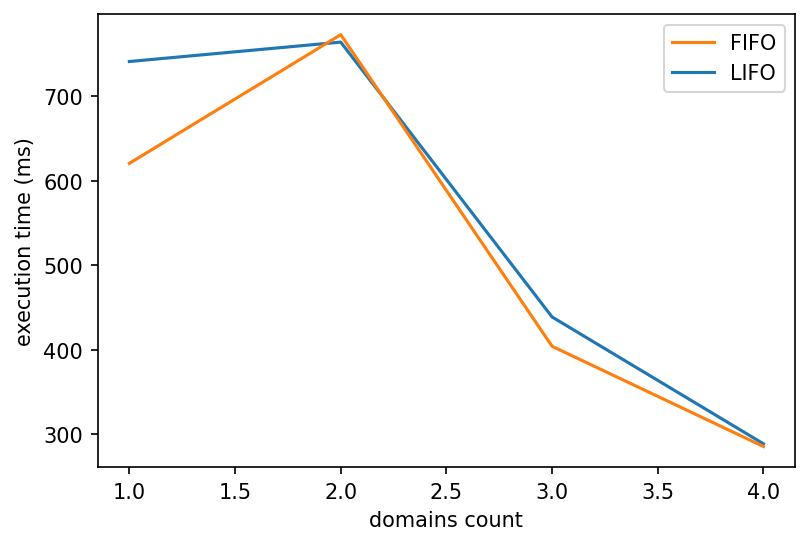

In [60]:
fig, ax = plt.subplots()
line_lifo, = ax.plot(x, lifo_time, label='LIFO')
line_fifo, = ax.plot(x, fifo_time, label='FIFO')
ax.legend(handles=[line_fifo, line_lifo])

plt.xlabel('domains count')
plt.ylabel('execution time (ms)')
plt.show()

### Latency vs number of domains

In [83]:
def to_time_ms(x):
    return (2 ** np.array(x)) / (10 ** 3)

fifo_median_latency = [to_time_ms(find_percentile(v[1],0.5)) for v in fifo]
fifo_q99_latency = [to_time_ms(find_percentile(v[1],0.99)) for v in fifo]

lifo_median_latency = [to_time_ms(find_percentile(v[1],0.5)) for v in lifo]
lifo_q99_latency = [to_time_ms(find_percentile(v[1],0.99)) for v in lifo]

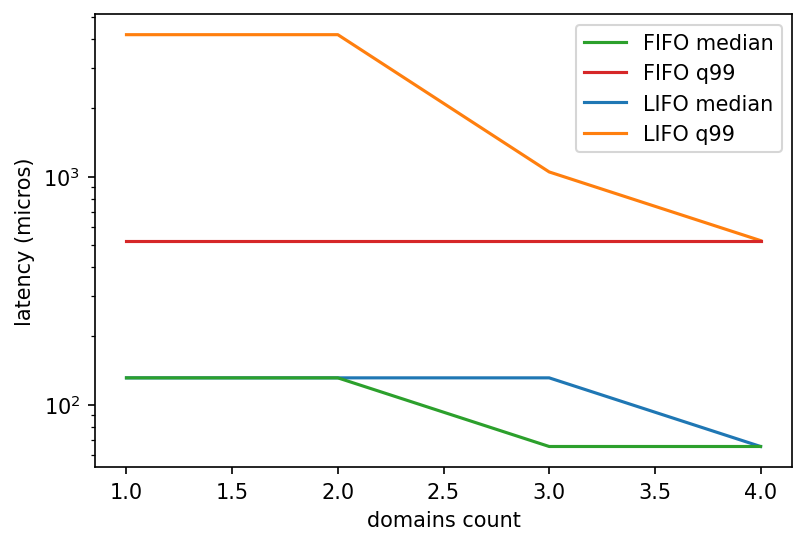

In [84]:
fig, ax = plt.subplots()
line_lifo_median, = ax.plot(x, lifo_median_latency, label='LIFO median')
line_lifo_q99, = ax.plot(x, lifo_q99_latency, label='LIFO q99')
line_fifo_median, = ax.plot(x, fifo_median_latency, label='FIFO median')
line_fifo_q99, = ax.plot(x, fifo_q99_latency, label='FIFO q99')
ax.legend(handles=[line_fifo_median, line_fifo_q99, line_lifo_median, line_lifo_q99])
ax.set_yscale('log')

plt.xlabel('domains count')
plt.ylabel('latency (micros)')
plt.show()

### Realized skewness

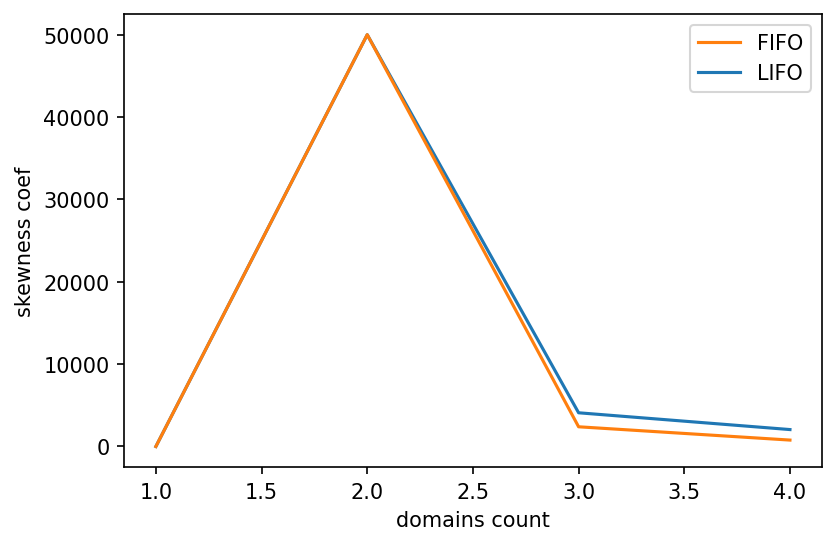

In [88]:
fifo_skewness = [v[2] for v in fifo]
lifo_skewness = [v[2] for v in lifo]

fig, ax = plt.subplots()
line_lifo, = ax.plot(x, fifo_skewness, label='LIFO')
line_fifo, = ax.plot(x, lifo_skewness, label='FIFO')
ax.legend(handles=[line_fifo, line_lifo])

plt.xlabel('domains count')
plt.ylabel('skewness coef')
plt.show()

# Experiment 2, simple workload, not skewed 

# Data collection

In [89]:
param_space = range(1,7)

fifo = []
for i in param_space:
    fifo.append(run("FIFO", domains=i, spawners=i))

lifo = []
for i in param_space:
    lifo.append(run("LIFO", domains=i, spawners=i))
    
x = list(param_space)

# Analysis

In [98]:
fifo_time = [v[0] for v in fifo]
lifo_time = [v[0] for v in lifo]

### Exec time vs number of domains

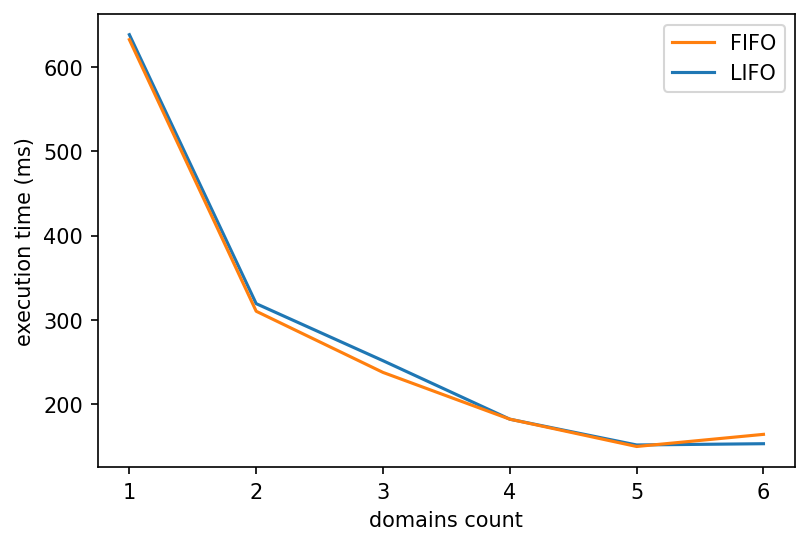

In [99]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

fig, ax = plt.subplots()
line_lifo, = ax.plot(x, lifo_time, label='LIFO')
line_fifo, = ax.plot(x, fifo_time, label='FIFO')
ax.legend(handles=[line_fifo, line_lifo])

plt.xlabel('domains count')
plt.ylabel('execution time (ms)')
plt.show()

### Latency vs number of domains

In [108]:
fifo_median_latency = [to_time_ms(find_percentile(v[1],0.5)) for v in fifo]
fifo_q95_latency = [to_time_ms(find_percentile(v[1],0.95)) for v in fifo]

lifo_median_latency = [to_time_ms(find_percentile(v[1],0.5)) for v in lifo]
lifo_q95_latency = [to_time_ms(find_percentile(v[1],0.95)) for v in lifo]

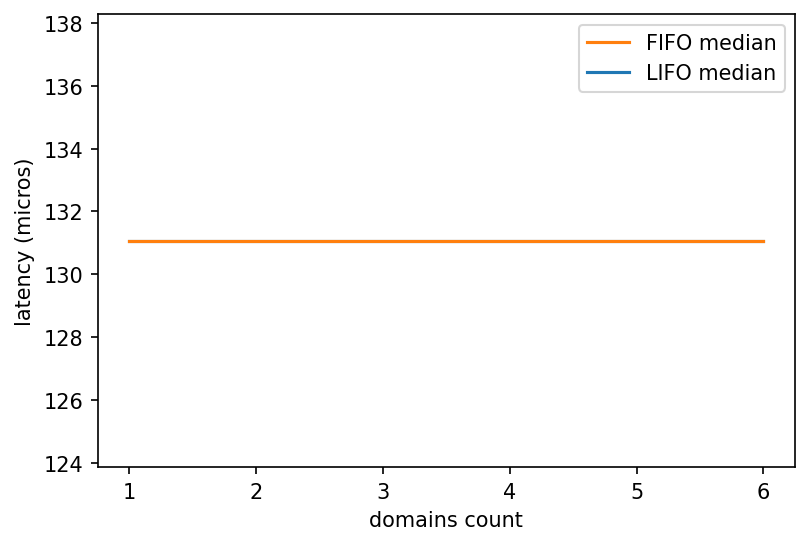

In [109]:
fig, ax = plt.subplots()
line_lifo_median, = ax.plot(x, lifo_median_latency, label='LIFO median')
line_fifo_median, = ax.plot(x, fifo_median_latency, label='FIFO median')
ax.legend(handles=[line_fifo_median, line_lifo_median])

plt.xlabel('domains count')
plt.ylabel('latency (micros)')
plt.show()

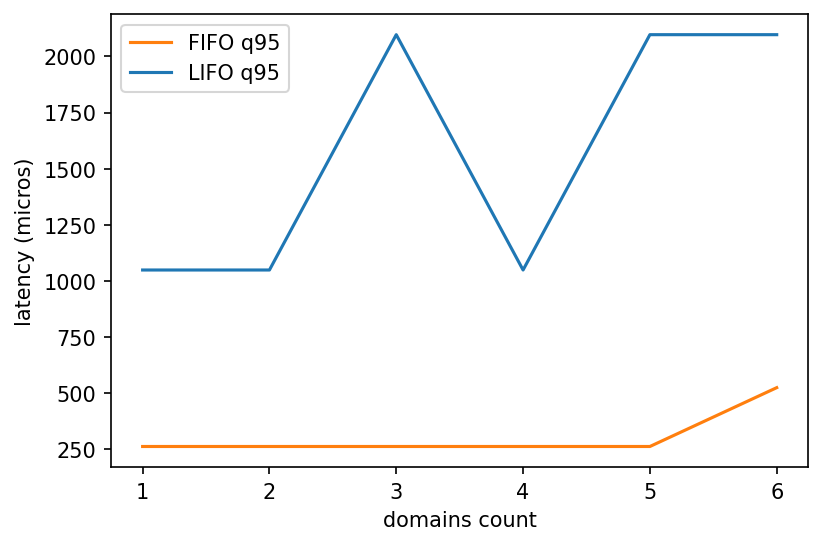

In [110]:
fig, ax = plt.subplots()
line_lifo_q95, = ax.plot(x, lifo_q95_latency, label='LIFO q95')
line_fifo_q95, = ax.plot(x, fifo_q95_latency, label='FIFO q95')
ax.legend(handles=[line_fifo_q95, line_lifo_q95])

plt.xlabel('domains count')
plt.ylabel('latency (micros)')
plt.show()

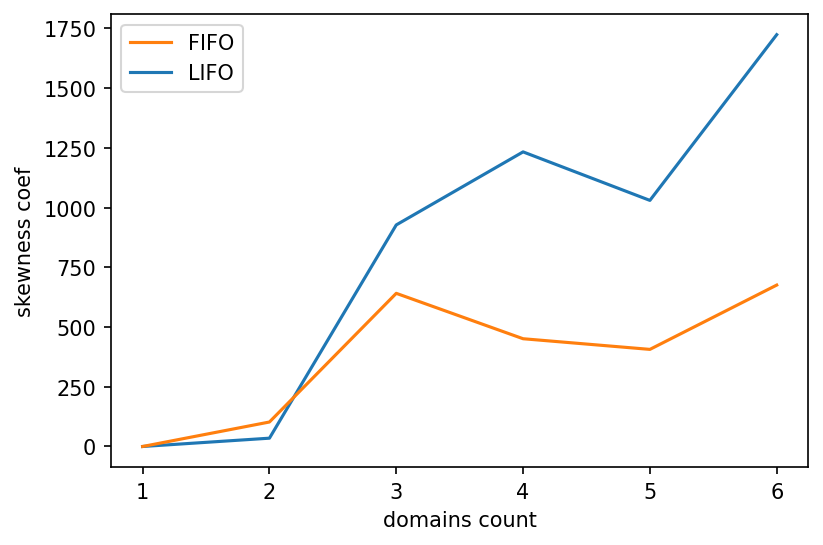

In [111]:
fifo_skewness = [v[2] for v in fifo]
lifo_skewness = [v[2] for v in lifo]

fig, ax = plt.subplots()
line_lifo, = ax.plot(x, fifo_skewness, label='LIFO')
line_fifo, = ax.plot(x, lifo_skewness, label='FIFO')
ax.legend(handles=[line_fifo, line_lifo])

plt.xlabel('domains count')
plt.ylabel('skewness coef')
plt.show()

# Conclusion I: While the average runtimes are comparable, LIFO implementation seems to be worse at distributing the load evenly.

Perhaps a consequence of how we fix yielding?

# Experiment 3: even if LIFO implementation is somewhat worse, are there any cases where LIFO seems to be worth pursing?

Yes, although it does take a lot to show that. E.g. task with strong cache dependencies running on a single domain.

In [114]:
exec_path = repo_path[0] + "/_build/default/test/benchmark_process_packet_artifical.exe"

cmd = exec_path + " -scheduler FIFO -num-of-domains 1 -num-of-spawners 15"
fifo = !$cmd

cmd = exec_path + " -scheduler LIFO -num-of-domains 1 -num-of-spawners 15"
lifo = !$cmd

In [127]:
def get_mean_time(data):
    data = data[1:-1]
    
    grouped_time = [] 
    for i in range(1,round(len(data)/4)):
        index = i*4
        
        assert (data[index+1][:5] == "time:")
        time = int(data[index+1][5:]) 
        grouped_time.append(time)
    
    return np.mean(time)
        


In [128]:
get_mean_time(fifo)

1082.0

In [129]:
get_mean_time(lifo)

983.0

In [139]:
def get_latency(data):
    data = data[1:-1]
    
    grouped_latency = []
    for i in range(1,round(len(data)/4)):
        index = i*4
        
        assert (data[index+2][:8] == "latency:")
        latency = data[index+2][8:]
        grouped_latency.append(json.loads(latency))
    
    return grouped_latency
    

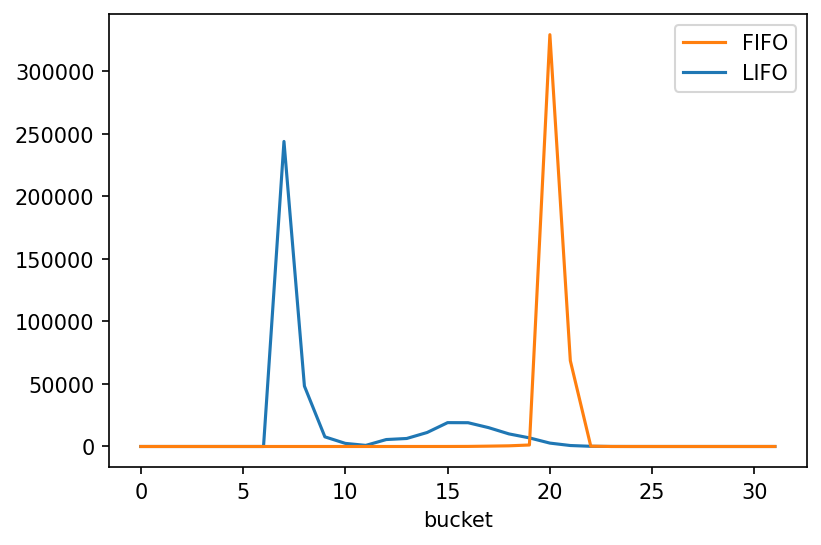

In [150]:
fig, ax = plt.subplots()
line_lifo, = ax.plot(np.mean(get_latency(lifo), axis=0), label='LIFO')
line_fifo, = ax.plot(np.mean(get_latency(fifo), axis=0), label='FIFO')
ax.legend(handles=[line_fifo, line_lifo])

plt.xlabel('bucket')
plt.ylabel('')
plt.show()